# Challenge Problem 3: Genome Wide Association Study

## Background:

(Adapted From BMI 704, Dr. Chirag Patel)

Genome-wide association studies (GWASs) are arguably the most significant biomedical advance in the last decade. Utilizing an observational case-control design, populations with disease are analytically compared to those without to discern patterns in differences in genetic variant, or single nucleotide polymorphism (SNP),frequencies in each of the respective populations. If statistically differences in SNP frequencies in cases vs
controls are found, one can conclude the SNP locus may have a causal relationship, implicating a gene, genetic region, or gene regulator in the disease of interest.

Analyzing GWASs provide lessons in observational research, including statistical association and multiple testing. They also provide a way to create hypotheses about biological basis of disease for further study. We will execute a GWAS analysis using data from the Wellcome Trust Case-Control Consortium (WTCCC) on Type 2 Diabetes, Type 1 Diabetes, Bipolar Disorder, Rheumatoid Arthritis, Chron's Disease and Hypertension versus 1,500 controls.

Note: There are standard tools and pipelines available to do this but we will do it the old fashioned way!

The Data is provided in separate directories under the primary WTCCC directory. The subdirectories are labeled as such:
* 58C : control population 1
* NBS : control population 2
* RA : rheumatoid arthritis
* T2D : type 2 diabetes
* T1D : type 1 diabetes
* CAD : coronary artery disease
* HT : hypertension
* CD : Crohn’s disease
* BD : bipolar disorder

All of the GWAS data is broken down per chromosome, 1-22 plus X and is written into the file name, as well as the disease. For example:

Affx_gt_ 58C _Chiamo_ 06 .tped.gz

Contains GWAS data for the 6th (06) chromosome on control population 1 (58C). The biggest files are chromosome 1 and 2 and smallest is 22.


Each row is a SNP (there are 6207 SNPs measured in Chromosome 22). The first through fourth columns denote the chromosome number, the second is the WTCCC snp_id (not to be confused with the rsid), the start coordinate (0), and the end coordinate. Thereafter, each column is a genotype (where each base is separated by a space character) for that SNP for each individual.

Additionally, each subdirectory also contains a ‘snps_info.tar.gz’, which contains the snp_id and rsID for each SNP for each chromosome. These files can enable you to map the WTCCC snp_id to the rsid, which is helpful to find the closest genes to a SNP (for example when you query the GWAS catalog).

In [1]:
import pandas as pd
from os import path
import csv
import numpy as np
from time import time
import numpy as np
import scipy.stats as stats
import time
from collections import Counter
from scipy.stats import chi2_contingency
from scipy.stats.distributions import chi2

In [129]:
## function to load the data file
def getData(file):
    
    '''
    Input
    -----
    a dataframe that if formatted like to above files
    
    Out
    ---
    the 'data', the people's snp data
    '''
    
    return(file.loc[:, 4:])

def loadFile (disease, chrom_num):
    ## construct your file name based on the disease and chrom_number
    '''
    Inputs
    ------
    chrom_num (int) The chromosome #
    disease (str) The abbreviation for the disease e.g. 'BD' or the control 'CTRL' case insensitive.
    Can also input 'SNP' to load a SNP file.
    
    Output
    ------
    The dataframe instance pd.DataFrame
    '''
    disease = disease.upper()
    if disease == 'CTRL':
        if chrom_num < 10:
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/58C/Affx_gt_58C_Chiamo_0{}.tped.gz'.format(chrom_num)
            dat1 = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/NBS/Affx_gt_NBS_Chiamo_0{}.tped.gz'.format(chrom_num)
            dat2 = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
        else:
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/58C/Affx_gt_58C_Chiamo_{}.tped.gz'.format(chrom_num)
            dat1 = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/NBS/Affx_gt_NBS_Chiamo_{}.tped.gz'.format(chrom_num)
            dat2 = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
        dat = pd.concat((dat1, getData(dat2)), ignore_index=True, axis=1)
    elif disease == 'SNP':
        if chrom_num < 10:
            snp_file = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/58C/snps/snps_0{}'.format(chrom_num)
            dat = pd.read_csv(snp_file, header=None, sep='\t')
            dat = dat.loc[:, 3:4]
            dat.rename(inplace=True, columns={3:'SNP', 4:'rsID'})
        else:
            snp_file = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/58C/snps/snps_{}'.format(chrom_num)
            dat = pd.read_csv(snp_file, header=None, sep='\t')
            dat = dat.loc[:, 3:4]
            dat.rename(inplace=True, columns={3:'SNP', 4:'rsID'})
    else:
        if chrom_num < 10:
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/{}/Affx_gt_{}_Chiamo_0{}.tped.gz'.format(disease, disease, chrom_num)
        else:
            fileName = 'C:/Users/saketh/stuff/Medlytics/Week3Public/BWSI_100set/{}/Affx_gt_{}_Chiamo_{}.tped.gz'.format(disease, disease, chrom_num)
        dat = pd.read_csv(fileName, compression='gzip', header=None, sep='\t')
    return (dat)

def getHeader(file):
    '''
    Input
    -----
    a dataframe that if formatted like to above files
    
    Out
    ---
    the 'header', columns 0 thru 3
    '''
    
    return(file.loc[:, 0:3])



In [130]:

def getSNPmap(chr_num, ctrl):
    header = getHeader(ctrl)
    snpinfo = loadFile('SNP', chr_num)
    header.rename(columns={1:'SNP'}, inplace=True)
    snpdict = header.join(snpinfo.set_index('SNP'), on='SNP', how='left')
    return snpdict
getSNPmap(1, loadFile('CTRL', 1))

,0,SNP,2,3,rsID
0,1,SNP_A-1938722,0,15385344,rs761296
1,1,SNP_A-4217222,0,243847383,rs11582843
2,1,SNP_A-2023862,0,192847341,rs3009323
3,1,SNP_A-4196224,0,95890895,rs17114028
4,1,SNP_A-2286934,0,189084167,rs16832860
5,1,SNP_A-2126188,0,72890843,rs4233087
6,1,SNP_A-2056136,0,183005923,rs861590
7,1,SNP_A-2168773,0,42680602,rs2809664
8,1,SNP_A-4241328,0,150784469,rs7518654
9,1,SNP_A-1872388,0,99556479,rs2148154


In [131]:
## compute Allele Frequency for the minor allele
def minorFrq(matrix, group=0):
    '''
    get the minor allele frequency after inputting matrix and 1 for 'control' or 0 for 'disease'
    '''
    return(matrix[group, 0]/(matrix[group, 1]+matrix[group, 0]))

def majorMinorAllele(snp):
    '''
    Enter SNP
    Get minor then major allele both counts then both letters
    '''
    cnt = Counter(snp.to_string())
    c = cnt['C']
    g = cnt['G']
    a = cnt['A']
    t = cnt['T']
    nozero = [u for u in [c, g, a, t] if u != 0.0]
    small = np.min(nozero)
    big = np.max(nozero)
    l_small = 'b'
    l_big = 'b'
    if small == c:
        l_small = 'C'
    elif small == g:
        l_small = 'G'
    elif small == a:
        l_small = 'A'
    else:
        l_small = 'T'
    if big == c:
        l_big = 'C'
    elif big == g:
        l_big = 'G'
    elif big == a:
        l_big = 'A'
    else:
        l_big = 'T'
    return (small, big, l_small, l_big)

def conf_matrix(snp_healthy, snp_disease):
    '''
    Pass a healthy SNP and a disease SNP and get in return
    a list of all of the numbers of alleles in the order
    A, C, G, T
    '''

    cnt_h = Counter(snp_healthy.to_string())
    cnt_d = Counter(snp_disease.to_string())
    c_h = cnt_h['C']
    g_h = cnt_h['G']
    a_h = cnt_h['A']
    t_h = cnt_h['T']
    c_d = cnt_d['C']
    g_d = cnt_d['G']
    a_d = cnt_d['A']
    t_d = cnt_d['T']

    retval = np.array([i for i in [a_d, c_d, g_d, t_d, a_h, c_h, g_h, t_h] if i != 0]).reshape((2, 2))
    if retval[0, 0] > retval[0, 1]:
        retval = np.flip(retval, axis=1)
    return retval

def zygosity(snp):
    '''
    Returns 'Ho or He' (a zygosity check)
    '''
    heter = np.unique(snp)
    
    if heter.shape[0] != 3:
        return 'Ho'
    else:
        return 'He'

In [136]:
fulldata = pd.DataFrame()
control_dataset = []
disease_dataset = []
snpmaps = pd.DataFrame()

def loadStuff(empty):
    time2 = time.time()
    snpmap = pd.DataFrame()
    for p in range(1, 23):
        control = loadFile('CTRL', p)
        control_dataset.append(getData(control))
        disease = loadFile('BD', p)
        disease_dataset.append(getData(disease))
        print(getSNPmap(p, control))
        snpmap = pd.concat((snpmap, getSNPmap(p, control)), axis=0, ignore_index=True)
    print("Loaded in " + str(time.time() - time2))
    return snpmap
    
snpmaps = loadStuff(snpmaps)    

    0            SNP  2          3        rsID
0   1  SNP_A-1938722  0   15385344    rs761296
1   1  SNP_A-4217222  0  243847383  rs11582843
2   1  SNP_A-2023862  0  192847341   rs3009323
3   1  SNP_A-4196224  0   95890895  rs17114028
4   1  SNP_A-2286934  0  189084167  rs16832860
5   1  SNP_A-2126188  0   72890843   rs4233087
6   1  SNP_A-2056136  0  183005923    rs861590
7   1  SNP_A-2168773  0   42680602   rs2809664
8   1  SNP_A-4241328  0  150784469   rs7518654
9   1  SNP_A-1872388  0   99556479   rs2148154
10  1  SNP_A-4278084  0    7343491    rs705672
11  1  SNP_A-1807549  0  204834561  rs11119107
12  1  SNP_A-2218949  0  230191312  rs16855881
13  1  SNP_A-4212440  0  237373091   rs6657123
14  1  SNP_A-4304379  0  207172970   rs4844451
15  1  SNP_A-2096146  0  111369155   rs7549595
16  1  SNP_A-2294163  0   67776216  rs12142258
17  1  SNP_A-1967356  0  153084977   rs1218563
18  1  SNP_A-2107677  0  115560916   rs1146179
19  1  SNP_A-2190239  0   10829795   rs1292665
20  1  SNP_A-

    0            SNP  2          3        rsID
0   4  SNP_A-4252320  0  153169015  rs17028429
1   4  SNP_A-2272244  0   73418858  rs12508636
2   4  SNP_A-1925727  0   24472885  rs41499048
3   4  SNP_A-1793355  0   20697443   rs4599408
4   4  SNP_A-4288330  0  169929444   rs7679982
5   4  SNP_A-1928945  0   11308503  rs16885955
6   4  SNP_A-1976950  0   42545916   rs2100251
7   4  SNP_A-2009641  0   21641030   rs7659568
8   4  SNP_A-4296838  0    9787266  rs17385872
9   4  SNP_A-2306754  0   20943383  rs16870831
10  4  SNP_A-2244609  0   16702065  rs16894317
11  4  SNP_A-2078805  0    7814661   rs2269850
12  4  SNP_A-2111962  0   11206083  rs11732793
13  4  SNP_A-1976957  0   42628253  rs10517062
14  4  SNP_A-2205551  0    7768529  rs16840900
15  4  SNP_A-1976743  0   34147175  rs16989701
16  4  SNP_A-4245218  0   47791538   rs1003873
17  4  SNP_A-2099991  0   11228089  rs16884697
18  4  SNP_A-4252304  0  172760304  rs17057147
19  4  SNP_A-1976263  0   16754307  rs16894448
20  4  SNP_A-

    0            SNP  2          3        rsID
0   7  SNP_A-2053481  0   84621956   rs1019204
1   7  SNP_A-2079123  0  111424476     rs29475
2   7  SNP_A-2218191  0  149690535  rs17173682
3   7  SNP_A-1832343  0  113962963   rs7788341
4   7  SNP_A-2040726  0   41160614     rs28314
5   7  SNP_A-1865784  0  134174606   rs1026273
6   7  SNP_A-1798049  0   14609601   rs1525089
7   7  SNP_A-2204069  0    1952507  rs10950458
8   7  SNP_A-1876952  0  151950636  rs10257825
9   7  SNP_A-1991732  0  148690937   rs1525523
10  7  SNP_A-2067656  0  143379817   rs2961148
11  7  SNP_A-2265190  0  118808622   rs2402483
12  7  SNP_A-1954894  0   92898496  rs17165412
13  7  SNP_A-1928388  0   56031756  rs10229446
14  7  SNP_A-4237814  0   12919298  rs17166514
15  7  SNP_A-4217935  0   96060726   rs1524924
16  7  SNP_A-2291396  0  101233627  rs11767486
17  7  SNP_A-1944096  0   54735133   rs1569256
18  7  SNP_A-2227606  0   51697303  rs13437668
19  7  SNP_A-4229415  0   43140884   rs2159199
20  7  SNP_A-

     0            SNP  2          3        rsID
0   10  SNP_A-2212182  0   65442680  rs12360285
1   10  SNP_A-2031679  0   61602593  rs10821692
2   10  SNP_A-2036862  0   29642204  rs16930152
3   10  SNP_A-4199118  0   65388685   rs2253077
4   10  SNP_A-4268311  0   64273665  rs16917743
5   10  SNP_A-2150238  0  107053616   rs2900698
6   10  SNP_A-2179554  0   61431453   rs7912611
7   10  SNP_A-1995661  0   12875594   rs2493766
8   10  SNP_A-1802944  0    3209794   rs6602036
9   10  SNP_A-1902658  0   64606685       rs907
10  10  SNP_A-2300513  0  112147984  rs17824180
11  10  SNP_A-1941913  0   87507487   rs2949380
12  10  SNP_A-4242263  0    8616167  rs17143959
13  10  SNP_A-2304557  0   98906772   rs2784912
14  10  SNP_A-2056347  0   61206161  rs10821593
15  10  SNP_A-2160775  0   14369232   rs1228333
16  10  SNP_A-1857653  0   79909431  rs16935995
17  10  SNP_A-2220022  0     328313   rs3123236
18  10  SNP_A-4272415  0   87197308  rs17396303
19  10  SNP_A-1958474  0   69451202  rs1

     0            SNP  2          3        rsID
0   13  SNP_A-2131993  0   82988642  rs12857023
1   13  SNP_A-1839995  0   32453277   rs4941726
2   13  SNP_A-1868555  0  107572958   rs9559260
3   13  SNP_A-2211582  0   90867353   rs7333580
4   13  SNP_A-2102868  0   36840242  rs17055414
5   13  SNP_A-2167237  0   44555195   rs7323288
6   13  SNP_A-2056840  0   58971400   rs1414979
7   13  SNP_A-1830847  0   72367334   rs9796066
8   13  SNP_A-1902737  0  102256492  rs12584268
9   13  SNP_A-2138966  0   53346514   rs4242932
10  13  SNP_A-4299880  0   23988156   rs9553330
11  13  SNP_A-2180765  0  101752488   rs1336664
12  13  SNP_A-2154718  0   70483115  rs17620171
13  13  SNP_A-2247405  0   99641482   rs7993680
14  13  SNP_A-2029699  0   25856163   rs2182850
15  13  SNP_A-4235098  0   50082426   rs1262720
16  13  SNP_A-4282000  0   25700935  rs10507353
17  13  SNP_A-2106317  0   81383535   rs7491779
18  13  SNP_A-2187688  0  108924218   rs9301386
19  13  SNP_A-2133832  0   88620754   rs

     0            SNP  2         3        rsID
0   16  SNP_A-1839415  0  81402874   rs1564026
1   16  SNP_A-2195647  0  17148629   rs2125190
2   16  SNP_A-2158594  0  74832948  rs12596723
3   16  SNP_A-2284990  0  19971996   rs2608178
4   16  SNP_A-4240990  0   8189275    rs733632
5   16  SNP_A-2254074  0  63776188  rs11644282
6   16  SNP_A-1857009  0  49867373   rs7189060
7   16  SNP_A-2228974  0  20196298   rs6497465
8   16  SNP_A-1851438  0  19618970   rs6497395
9   16  SNP_A-2081886  0  53307134  rs11646434
10  16  SNP_A-4290317  0  65322310   rs2067040
11  16  SNP_A-2231701  0   2387029  rs13330069
12  16  SNP_A-1797962  0  82890101   rs2042436
13  16  SNP_A-2093825  0  71951073  rs17291082
14  16  SNP_A-4229807  0  64641288  rs41356047
15  16  SNP_A-2175910  0  28172173   rs7204045
16  16  SNP_A-1957734  0  75924089   rs6564427
17  16  SNP_A-4302005  0   9959941  rs16966731
18  16  SNP_A-2287879  0  85693454   rs8051472
19  16  SNP_A-1812253  0  79861260   rs4889294
20  16  SNP_A

     0            SNP  2         3        rsID
0   19  SNP_A-1859129  0  36035295  rs10402875
1   19  SNP_A-2268377  0   2510841   rs2907334
2   19  SNP_A-2305296  0  63610149  rs11671591
3   19  SNP_A-2262511  0  63274609   rs2547353
4   19  SNP_A-1806381  0  59374787     rs40167
5   19  SNP_A-4288110  0  52484949  rs10853782
6   19  SNP_A-1782604  0   9888470   rs8104943
7   19  SNP_A-4282767  0  33301727    rs934106
8   19  SNP_A-1932928  0  53018384  rs17272603
9   19  SNP_A-1814614  0  51615592    rs453394
10  19  SNP_A-1871847  0  59506905    rs741584
11  19  SNP_A-1891189  0  57668193    rs979158
12  19  SNP_A-4246804  0  40589758  rs10420543
13  19  SNP_A-1940714  0  61673194   rs3760848
14  19  SNP_A-1889080  0  53228452  rs17663529
15  19  SNP_A-2285867  0  48445318  rs11083698
16  19  SNP_A-2245690  0  45879279   rs2561543
17  19  SNP_A-1791906  0  60848259  rs11084406
18  19  SNP_A-2085027  0  35568991  rs12462707
19  19  SNP_A-2291356  0  55665288   rs1274596
20  19  SNP_A

     0            SNP  2         3        rsID
0   22  SNP_A-4234155  0  32056663  rs12484156
1   22  SNP_A-2223191  0  35653934    rs909486
2   22  SNP_A-4202732  0  32956968   rs1873230
3   22  SNP_A-1811354  0  46997362   rs7287281
4   22  SNP_A-1797179  0  32955711   rs1003935
5   22  SNP_A-1848186  0  34009951   rs2272789
6   22  SNP_A-4300107  0  32474498  rs17807797
7   22  SNP_A-2066692  0  22147891   rs5759844
8   22  SNP_A-1884396  0  26701485   rs5762425
9   22  SNP_A-4223629  0  43534919    rs132450
10  22  SNP_A-1808824  0  26221715  rs17464499
11  22  SNP_A-1799634  0  24261372   rs1467387
12  22  SNP_A-1897160  0  25938087   rs7285459
13  22  SNP_A-4237872  0  48629723   rs4141437
14  22  SNP_A-2219042  0  46697999   rs5768168
15  22  SNP_A-1970946  0  30060821  rs17820970
16  22  SNP_A-1904662  0  21769756   rs5996464
17  22  SNP_A-2218258  0  20637519    rs412050
18  22  SNP_A-1971122  0  41012501    rs134898
19  22  SNP_A-1905030  0  31421592   rs5998588
20  22  SNP_A

In [139]:
snpmaps

,0,SNP,2,3,rsID
0,1,SNP_A-1938722,0,15385344,rs761296
1,1,SNP_A-4217222,0,243847383,rs11582843
2,1,SNP_A-2023862,0,192847341,rs3009323
3,1,SNP_A-4196224,0,95890895,rs17114028
4,1,SNP_A-2286934,0,189084167,rs16832860
5,1,SNP_A-2126188,0,72890843,rs4233087
6,1,SNP_A-2056136,0,183005923,rs861590
7,1,SNP_A-2168773,0,42680602,rs2809664
8,1,SNP_A-4241328,0,150784469,rs7518654
9,1,SNP_A-1872388,0,99556479,rs2148154


## Hardy Weinberg Equilibrium

In [137]:
## Function takes as input the minor allele frequency (p) and the population genotype counts
## returns the p-value from the chisq test
def HWEChiSq (snp):
    """
    Inputs
    ------
    the SNP of the control.
    
    
    Output
    ------
    the p value
    
        |  CC | CT  | TT |
    BP  | 270 | 957 | 771|
    compute the HWE
      -- p = frequency of the C allele
      -- q = 1-p = frequency of the T allele
      -- if the population genotype is in Hardy Weinberg Equilibrium, we would expect the genotype frequencies to be
          CC = p^2*N 
          CT = 2pq*N 
          TT = q^2*N 
      -- to compute the deviation from HWE
         (observed - expected)^2 / expected
      -- do a chi.squared test to check if the deviation is significant
    """
    genes = np.unique(snp, return_counts=True)
    a1 = genes[1][0]
    b1 = genes[1][1]
    c1 = genes[1][2]
    t = a1 + b1 + c1
    al1 = 2 * a1 + b1
    al2 = 2 * c1 + b1
    
    obs = np.array([a1,b1,c1])
    exp = np.array([(al1/(al1 + al2))**2 * t , 2 * (al1 * al2)/((al1 + al2)**2) * t, (al2/(al1 + al2))**2 * t])
    HWE = ((obs - exp) ** 2)/exp
    #print(stats.distributions.chi2.sf(np.sum(HWE), 1))
    return stats.distributions.chi2.sf(np.sum(HWE), 1)

In [138]:
def odds_ratio(matrix):
    '''
    Input the matrix
    and return the odds ratio.
    '''
    
    ratio = (matrix[0, 0]*matrix[1, 1]/(matrix[1, 0]*matrix[0, 1]))
    return(ratio)

def orp(matrix):
    return chi2_contingency(matrix)[1]

In [140]:
fulldata = pd.DataFrame()
chromosome = pd.DataFrame()
for k in range(1, 23, 1):
    
    control_data = control_dataset[k-1]
    disease_data = disease_dataset[k-1]
    time1 = time.time()
    chromosome = pd.DataFrame()
    
    for i in range(len(disease_data)):
        if zygosity(control_data.iloc[i]) == 'He' and zygosity(disease_data.iloc[i]) == 'He':
            
            c_snp = control_data.iloc[i]
            d_snp = disease_data.iloc[i]
            
            #print('after 1..............' + str(time.time() - time1)) ################################### 1
            #time1 = time.time()
            
            mat = conf_matrix(c_snp, d_snp)
            
            #print('after 2..............' + str(time.time() - time1)) ################################### 2
            #time1 = time.time()

            b = snpmaps.loc[(k-1) * 100 + i, 'SNP']
            c = snpmaps.loc[(k-1) * 100 + i, 'rsID']
            
            
        
            disease_alleles = majorMinorAllele(d_snp)
            control_alleles = majorMinorAllele(c_snp)
            d = control_alleles[2]
            e = control_alleles[3]
            f = disease_alleles[2]
            g = disease_alleles[3]
            
            #print('after 3..............' + str(time.time() - time1)) ################################### 3
            #time1 = time.time()
            
            h = minorFrq(mat, group=0)
            j = minorFrq(mat, group=1)
            m = odds_ratio(mat)
            n = orp(mat)
            o = HWEChiSq(c_snp)
            
            #print('after 4..............' + str(time.time() - time1)) ################################### 4
            #time1 = time.time()
            
            chromosome = chromosome.append(pd.DataFrame([[k, b, c, d, e, f, g, h, j, m, n, o]]))
            
            #print('after 5..............' + str(time.time() - time1)) ################################### 5
            #time1 = time.time()
            
            if i == 0:
                chromosome = pd.DataFrame([[k, b, c, d, e, f, g, h, j, m, n, o]])
    chromosome.rename(columns={0:'Chromosome #', 1:'SNP', 2:'rsID', 3:'Minor Allele Control', 4:'Major Allele Control', 5:'Minor Allele BD', 6:'Major Allele BD', 7:'Minor Allele Frequency Control', 8:'Minor Allele Frequency BD', 9:'OR', 10:'OR p', 11:'HWE p'}, inplace=True)
    print(chromosome.shape)
    fulldata = pd.concat((fulldata, chromosome), ignore_index=True, axis=0, sort=False)
    print("Finished Chromosome " + str(k) + ' in ' + str(time.time() - time1) + " seconds.")

(82, 12)
Finished Chromosome 1 in 15.156502485275269 seconds.
(78, 12)
Finished Chromosome 2 in 14.315811395645142 seconds.
(84, 12)
Finished Chromosome 3 in 14.67116403579712 seconds.
(85, 12)
Finished Chromosome 4 in 18.067145347595215 seconds.
(90, 12)
Finished Chromosome 5 in 16.291680574417114 seconds.
(92, 12)
Finished Chromosome 6 in 17.76719903945923 seconds.
(86, 12)
Finished Chromosome 7 in 15.628074407577515 seconds.
(81, 12)
Finished Chromosome 8 in 15.312159061431885 seconds.
(85, 12)
Finished Chromosome 9 in 15.460999965667725 seconds.
(85, 12)
Finished Chromosome 10 in 14.776294946670532 seconds.
(80, 12)
Finished Chromosome 11 in 14.04447054862976 seconds.
(88, 12)
Finished Chromosome 12 in 16.539852380752563 seconds.
(90, 12)
Finished Chromosome 13 in 16.363889932632446 seconds.
(86, 12)
Finished Chromosome 14 in 15.452851057052612 seconds.
(81, 12)
Finished Chromosome 15 in 15.949273586273193 seconds.
(88, 12)
Finished Chromosome 16 in 15.50010871887207 seconds.
(79, 

In [141]:
fulldata

,Chromosome #,SNP,rsID,Minor Allele Control,Major Allele Control,Minor Allele BD,Major Allele BD,Minor Allele Frequency Control,Minor Allele Frequency BD,OR,OR p,HWE p
0,1,SNP_A-1938722,rs761296,T,C,T,C,0.465465,0.460220,1.021324,0.620632,5.942010e-01
1,1,SNP_A-4217222,rs11582843,C,T,C,T,0.343093,0.347703,0.979817,0.650309,4.293534e-01
2,1,SNP_A-4196224,rs17114028,A,G,A,G,0.087087,0.091877,0.942887,0.432752,4.627370e-01
3,1,SNP_A-2286934,rs16832860,G,A,G,A,0.472973,0.466711,1.025458,0.552356,2.611405e-01
4,1,SNP_A-2126188,rs4233087,G,C,G,C,0.001752,0.004328,0.403745,0.043109,2.641999e-97
5,1,SNP_A-2056136,rs861590,C,A,C,A,0.473724,0.467210,1.026490,0.536003,3.507967e-01
6,1,SNP_A-4241328,rs7518654,C,G,C,G,0.360611,0.363182,0.988925,0.809633,9.516905e-01
7,1,SNP_A-1872388,rs2148154,G,A,G,A,0.446947,0.458722,0.953587,0.255097,8.323120e-01
8,1,SNP_A-4278084,rs705672,C,T,C,T,0.258008,0.258489,0.997494,0.975685,2.647269e-01
9,1,SNP_A-1807549,rs11119107,A,G,A,G,0.305055,0.293442,1.056947,0.221931,8.832205e-01


In [100]:
control_data = getData(loadFile('CTRL', 1))
disease_data = getData(loadFile('BD', 1))
i= 0
if zygosity(control_data.loc[i]) == 'He' and zygosity(disease_data.loc[i]) == 'He':
            
    c_snp = control_data.loc[i]
    d_snp = disease_data.loc[i]
          
    #print('after 1..............' + str(time.time() - time1)) ################################### 1
    #time1 = time.time()
          
    mat = conf_matrix(c_snp, d_snp)
          
    #print('after 2..............' + str(time.time() - time1)) ################################### 2
    #time1 = time.time()
          
    a = 1
    b = snpmaps[0].loc[i, 'SNP']
    c = snpmaps[0].loc[i, 'rsID']



    disease_alleles = majorMinorAllele(d_snp)
    control_alleles = majorMinorAllele(c_snp)
    d = control_alleles[2]
    e = control_alleles[3]
    f = disease_alleles[2]
    g = disease_alleles[3]

    #print('after 3..............' + str(time.time() - time1)) ################################### 3
    #time1 = time.time()

    h = minorFrq(mat, group=0)
    j = minorFrq(mat, group=1)
    m = odds_ratio(mat)
    n = orp(mat)
    o = HWEChiSq(c_snp)

    #print('after 4..............' + str(time.time() - time1)) ################################### 4
    #time1 = time.time()

    chrom = pd.DataFrame([[a, b, c, d, e, f, g, h, j, m, n, o]])

In [101]:
chrom

,0,1,2,3,4,5,6,7,8,9,10,11
0,1,SNP_A-1938722,NaN,T,C,T,C,0.465465,0.46022,1.021324,0.620632,0.594201


In [99]:
cf = conf_matrix(c_snp, d_snp) ##Fucntion is good
minorFrq(cf, group=0)

0.46546546546546547

In [105]:
fulldata

,Chromosome #,SNP,rsID,Minor Allele Control,Major Allele Control,Minor Allele BD,Major Allele BD,Minor Allele Frequency Control,Minor Allele Frequency BD,OR,OR p,HWE p,p_adj
0,1,SNP_A-1938722,NaN,T,C,T,C,0.534535,0.539780,0.979121,0.620632,0.000000e+00,0.207166
1,1,SNP_A-4217222,NaN,C,T,C,T,0.343093,0.347703,0.979817,0.650309,0.000000e+00,0.186880
2,1,SNP_A-4196224,NaN,A,G,A,G,0.087087,0.091877,0.942887,0.432752,0.000000e+00,0.363761
3,1,SNP_A-2286934,NaN,G,A,G,A,0.527027,0.533289,0.975174,0.552356,0.000000e+00,0.257781
4,1,SNP_A-2126188,NaN,G,C,G,C,0.998248,0.995672,2.476811,0.043109,0.000000e+00,1.365434
5,1,SNP_A-2056136,NaN,C,A,C,A,0.526276,0.532790,0.974194,0.536003,0.000000e+00,0.270833
6,1,SNP_A-4241328,NaN,C,G,C,G,0.360611,0.363182,0.988925,0.809633,0.000000e+00,0.091712
7,1,SNP_A-1872388,NaN,G,A,G,A,0.553053,0.541278,1.048672,0.255097,0.000000e+00,0.593295
8,1,SNP_A-4278084,NaN,C,T,C,T,0.258008,0.258489,0.997494,0.975685,0.000000e+00,0.010690
9,1,SNP_A-1807549,NaN,A,G,A,G,0.305055,0.293442,1.056947,0.221931,0.000000e+00,0.653782


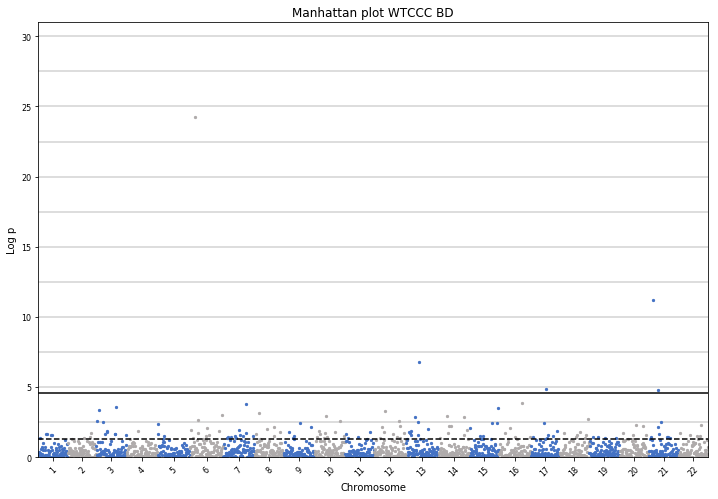

In [142]:
## plot the data
## manhattan plot
## the X axis represents the chromosomes 
## the y-axis is the -log(p.value)
# def manhattanPlot (diseaseResults):
#     """
#     group data by chromosomes, SNP before plotting
#     """
#     return 
filtered= fulldata.rename(columns={'Chromosome #':'Chromosome'})
import matplotlib.pyplot as plt
filtered['p_adj'] = -np.log10(filtered['OR p'])
filtered.Chromosome = filtered.Chromosome.astype('category')
filtered['ind'] = range(len(filtered))
filtered_grouped = filtered.groupby(('Chromosome'))
# print(df_grouped.head(10))
fig = plt.figure()
fig.set_size_inches(12, 8)
ax = fig.add_subplot(111)
colors = ['#4472C4','#AFABAB']
x_labels = []
x_labels_pos = []
for num, (name, group) in enumerate(filtered_grouped):
   group.plot(kind='scatter', x='ind', y='p_adj',color=colors[num % len(colors)], ax=ax, s=5, zorder=2)
   x_labels.append(name)
   x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))
ax.set_xticks(x_labels_pos)
ax.set_xticklabels(x_labels)
ax.set_xlim([0, len(filtered)])
ax.set_ylim([0, 31])
start, end = ax.get_ylim()
stepsize = 5
ax.yaxis.set_ticks(np.arange(start, end, stepsize))
ax.set_xlabel('Chromosome')
ax.set_ylabel('Log p')
plt.xticks(fontsize = 8, rotation=45)
plt.yticks(fontsize = 8)
plt.title('Manhattan plot WTCCC BD')
plt.axhline(y = -np.log10(0.05), color='black', linestyle='--', zorder=3)
plt.axhline(y = -np.log10(0.05 / 1854), color='black', linestyle='-',zorder=3)
for y in np.arange(start, end, 2.5):
   plt.axhline(y = y, color='#D3D3D3', linestyle='-', zorder=1)

In [ ]:
## Write code to run the GWAS

## Write a function that will take the following inputs:
## (a) control files - 58C and NBS
## (b) the disease - T2D, T1D, HT, BD, CD, RA
## (c) the chromosome number

## Your function should output a csv file with the following information
## SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, MAJOR ALLELE FREQUENCY, 
## ODDS RATIO (MINOR vs MAJOR ALLELE), P-Value for ODDS RATIO, Chi square for the ODDS RATIO, HWE deviation P-VALUE
## 

def gwas (controlFile, disease, chrom_num):
    """
    1. Load the control file for the specified chromosome number. Since there are two control populations, 
       it would be best to combine the two controls together
    2. Load the disease file for the given chromosome number
    3. Split the header from the SNP data for the controls and the disease
    3. Load the SNP file -- this gives you the mapping between the WTCCC SNP ids and the RSID
    4. For each SNP in the disease file and its matching SNP in the control file:
       -- to make it easier, before you begin do a check for zygosity. If either the controls or the disease 
       are homozygous, skip the SNP
       genotype CC, TT : skip
       genotype CC CT TT : run the following analysis
       a. get the minor and major allele counts and compute the minor allele frequency for the disease population
       b. get the minor and major allele counts and compute the minor allele frequency for the control population
       c. conduct the allelic test -- compute the odds ratios to test the frequency of the minor allele 
          in the disease population compared to the control population
          -- you can build a confusion matrix based on the counts that you have calculated in a and b
          -- compute your odds ratios based on the minor allele of the control population
          
          |                  | C    | T    | 
          |------------------+ ---  + ---  +
          | Bipolar Disorder | 1529 | 2469 |
          |------------------+----  + ---  +
          | Healthy Controls | 2270 | 3738 |
          |------------------+----- +----- +
          
          (Test : your OR for above should be :1.019)
       d. Do a chi square test to test the significant and record the p-value
       d. for each SNP calculate the deviation from Hardy-Weinberg equilibrium
       e. create an output row containing:
       SNP Id, RSID, CHROMOSOME NUMBER, MINOR ALLELE, MAJOR ALLELE, MINOR ALLELE FREQUENCY, 
       MAJOR ALLELE FREQUENCY, ODDS RATIO (MINOR vs MAJOR ALLELE), 
       P-Value for ODDS RATIO, CHI_SQ for the ODDS RATIO, HWE deviation P-VALUE  
    5. Save the result file for the chromosome
    """
    


In [ ]:
## Write a main function that will invoke gwas for all chromosomes (1 through 22, don't include the X chromosome)

def runGWAS (disease):
    """
    1. For each chromosome 1:22 call the gwas function
    2. Merge all the result files into one 
    3. Filter your data
       a. remove all SNPs that deviate signficantly from HWE equilibrium -- these may indicate an error or 
          population specific deviation. For this remove all SNPs for which HWE deviation P-Value < 0.05
       b. remove all SNPs that have minor allele frequency less than 1% -- not enough data
    4. Draw a manhattan plot
       c. draw a line at your Bonferroni threshold (Bonferroni correction): 
       if your significance is set at p.value < 0.05, then Bonferroni correction = 0.05/number of tests that you ran
    """

<img src="manhattan.png">

In [ ]:
## How many SNPs did you identify that exceeded the Bonferroni-level of significance?

## How much can you trust your results

Typically, you want to examine the genome-wide distribution of your chi_square distribution against an expected null distribution. Visually you can do this using a quantile-quantile plot. Significant deviation from the null distribution may point to population stratification, familial relationships, technical bias, poor sample collection or sometimes even undetected sample duplications.
(Slide courtesy - Dr. Chirag Patel)

<img src="qqplot_example.png">


In [ ]:
## Based on your results do a quantile-quantile plot for your data

##load your results 
##sort/order the -log10 of your p values in increasing order
##generate an expected set of -log10(p_values)
##plot the expected values on the x-axis and the observed -log10 (pvalues) on the y axis
##Alternatively use: p = observed p values
##stats.probplot(p, dist="norm", plot=pylab)
##pylab.show()


### Genomic Inflation Factor

Mathematically, you can correct for some of the deviation by computing an inflation factor and then correcting for this inflation factor. This quantity is termed as genomic inflation factor ($\lambda$)

$\lambda$ = observed median of test statistic distribution / expected median of the test statistic 
distribution.  For 1 degree of freedom, the X2 distribution has an expected median of 0.455

$\lambda$ <= 1.05 is considered acceptable. >1.1 is troubling, and indicates there is some inflation of the p values.


In [ ]:
## Compute the genomic inflation factor

##labmda =  median(CHI2)/qchisq(0.5, 1)
##if (gif > 1.05), correct your computed Chi.square values and recompute the p_values
##chi2_corrected = CHI2/lambda, 
##pval_corrected = pchisq(chi2_corrected, 1, lower.tail = F)
##re-draw the qqplot using the corrected pvalues (pval_corrected)


## What does this mean?

Identify a SNP that is significant (above the Bonferroni threshold). 
What is the p-value of association and odds ratio for the SNP?
What is the interpretation of the odds ratio? 
What gene is this SNP associated with and its putative function in your disease pathogenesis? 


## Polygenic Risk Scores (PRS)

A PRS is the cumulative risk of all SNP for a single patient. For example, if a patient has a 2 snps with OR=2 each, then their PRS is 4. The underlying assumption here is that each allele has an equal contribution and there is no interation between SNPS, that is the SNPS are independent. 

$prs =\sum_{i=1}^{m}-log_{10}(x_i) \cdot n_i$